<a href="https://colab.research.google.com/github/AndrsGzRo/incendios-forestales-mx/blob/main/Incendios_Forestales_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualización de Incendios Forestales

In [2]:
!pip install squarify

In [3]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import geopandas as gpd
import calendar

In [4]:
# Dataframe
url = 'https://raw.githubusercontent.com/AndrsGzRo/incendios-forestales-mx/refs/heads/main/data-2025-11-05.csv'
df = pd.read_csv(url)

# Primeros cincos renglones
df.head()

anio Clave_del_incendio    latitud    longitud  Clave_Municipio  \
0  2015         15-01-0001  21.995503 -102.750478              3.0   
1  2015         15-01-0002  21.773878 -102.300881              1.0   
2  2015         15-01-0003  21.785075 -102.319444              1.0   
3  2015         15-01-0004  22.224067 -102.336411              7.0   
4  2015         15-01-0005  22.041083 -101.973917              2.0   

           Estado        Municipio  CVE_ENT  CVE_MUN  CVEGEO  ...  \
0  Aguascalientes         Calvillo        1      3.0     301  ...   
1  Aguascalientes   Aguascalientes        1      1.0     101  ...   
2  Aguascalientes   Aguascalientes        1      1.0     101  ...   
3  Aguascalientes  Rincón de Romos        1      7.0     701  ...   
4  Aguascalientes         Asientos        1      2.0     201  ...   

          Entidad fn_Clave_del_incendio fn_Predio fn_Causa  \
0  Aguascalientes                   NaN       NaN      NaN   
1  Aguascalientes                   NaN       NaN      NaN   
2  Aguascalientes                   NaN       NaN      NaN   
3  Aguascalientes                   NaN       NaN      NaN   
4  Aguascalientes                   NaN       NaN      NaN   

   fn_Causa_especifica  fn_Duracion_dias fn_Tipo_de_incendio  \
0                  NaN               NaN                 NaN   
1                  NaN               NaN                 NaN   
2                  NaN               NaN                 NaN   
3                  NaN               NaN                 NaN   
4                  NaN               NaN                 NaN   

  fn_Tipo_Vegetacion fn_Tipo_impacto fn_Tamano  
0                NaN             NaN       NaN  
1                NaN             NaN       NaN  
2                NaN             NaN       NaN  
3                NaN             NaN       NaN  
4                NaN             NaN       NaN  

[5 rows x 41 columns]

## 1.1 Información de dataframe

In [5]:
def info_df(df):
    print('---------Información general del Dataframe---------')
    print(df.info())
    print('---------Estadísticas del df---------')
    print(df.describe())
    print('---------Valores nulos---------')
    print(df.isnull().sum().sort_values(ascending=False))
    print('---------Valores únicos---------')
    print(df.nunique())

info_df(df)

---------Información general del Dataframe---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71089 entries, 0 to 71088
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   anio                   71089 non-null  int64  
 1   Clave_del_incendio     71089 non-null  object 
 2   latitud                71089 non-null  float64
 3   longitud               71089 non-null  float64
 4   Clave_Municipio        71075 non-null  float64
 5   Estado                 71089 non-null  object 
 6   Municipio              71089 non-null  object 
 7   CVE_ENT                71089 non-null  int64  
 8   CVE_MUN                71089 non-null  float64
 9   CVEGEO                 71089 non-null  int64  
 10  Region                 71089 non-null  object 
 11  Predio                 71087 non-null  object 
 12  Causa                  71089 non-null  object 
 13  Causa_especifica       71089 non-null  object 
 14  Fe

## 1.2 Limpieza

Se eliminarán las variables que empiezan con ``` fn_``` ya que suelen ser valores nulos.




In [6]:
# Eliminando columnas fn
df_raw= df.copy()
df_clean= df_raw.loc[:,~df.columns.str.startswith('fn_')].copy()
info_df(df_clean)

---------Información general del Dataframe---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71089 entries, 0 to 71088
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   anio                71089 non-null  int64  
 1   Clave_del_incendio  71089 non-null  object 
 2   latitud             71089 non-null  float64
 3   longitud            71089 non-null  float64
 4   Clave_Municipio     71075 non-null  float64
 5   Estado              71089 non-null  object 
 6   Municipio           71089 non-null  object 
 7   CVE_ENT             71089 non-null  int64  
 8   CVE_MUN             71089 non-null  float64
 9   CVEGEO              71089 non-null  int64  
 10  Region              71089 non-null  object 
 11  Predio              71087 non-null  object 
 12  Causa               71089 non-null  object 
 13  Causa_especifica    71089 non-null  object 
 14  Fecha_Inicio        71086 non-null  float64
 15  F

### 1.3 Transformación de Variables

#### 1.3.1 Duracion_dias
Las variables anteriores tienen un formato correcto, excepto ```Duracion_dias```, la cual será transformada a una ordinal.


In [7]:
mapa_duraciones = {
    '1 Día': 1,
    '2 a 3 Días': 2.5,
    '4 a 7 Días':5.5,
    'Mayor de 7 Días':10
}
df_clean['Duracion_dias_num'] = df_clean['Duracion_dias'].map(mapa_duraciones)

#### 1.3.2 Fecha_Inicio y Fecha_Termino
Al estar en TimeStamp es necesario transformar las variables a DateTime para comprender mejor la duración de los incendios.

In [8]:
# Fecha Inicio
df_clean = df_clean.dropna(subset=['Fecha_Inicio'])
df_clean['Fecha_Inicio'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_clean['Fecha_Inicio'], unit='D')

# Fecha Termino
df_clean['Fecha_Termino'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_clean['Fecha_Termino'], unit='D')

# Año, mes y duracion
df_clean['anio_inicio'] = df_clean['Fecha_Inicio'].dt.year.astype(int)
df_clean['mes_inicio'] = df_clean['Fecha_Inicio'].dt.month
df_clean['duracion_real'] = (df_clean['Fecha_Termino'] - df_clean['Fecha_Inicio']).dt.days

#### 1.3.1 Estación del Año

In [9]:
def estacion(mes):
    if mes in [12,1,2]:
        return 'Invierno'
    elif mes in [3,4,5]:
        return 'Primavera'
    elif mes in [6,7,8]:
        return 'Verano'
    elif mes in [9,10,11]:
        return 'Otoño'
df_clean['estacion'] = df_clean['mes_inicio'].apply(estacion)

### 1.4 Normalización de Texto

#### 1.4.1 Causa

In [10]:
# Pasar todo a minúsculas y quitar espacios sobrantes
df_clean['Causa'] = df_clean['Causa'].str.strip().str.lower()
df_clean['Causa'].value_counts()

Causa
intencional                             13023
actividades agrícolas                   10843
desconocidas                             9269
actividades agropecuarias                8225
fogatas                                  6183
actividades ilícitas                     5991
actividades pecuarias                    4613
fumadores                                4217
cazadores                                1931
otras causas                             1926
quema de basureros                       1572
otras actividades productivas            1287
naturales                                1166
residuos de aprovechamiento forestal      228
limpias de derecho de vía                 218
festividades y rituales                   189
transportes                               124
cultivos ilícitos                          77
0                                           2
ninguna / no aplica                         2
Name: count, dtype: int64

In [11]:
# Juntando 0 y Ninguna/No Aplica
df_clean['Causa'] = df_clean['Causa'].replace({
    'ninguna / no aplica': 'no aplica',
    '0':'no aplica'
})
df_clean['Causa'].value_counts()

Causa
intencional                             13023
actividades agrícolas                   10843
desconocidas                             9269
actividades agropecuarias                8225
fogatas                                  6183
actividades ilícitas                     5991
actividades pecuarias                    4613
fumadores                                4217
cazadores                                1931
otras causas                             1926
quema de basureros                       1572
otras actividades productivas            1287
naturales                                1166
residuos de aprovechamiento forestal      228
limpias de derecho de vía                 218
festividades y rituales                   189
transportes                               124
cultivos ilícitos                          77
no aplica                                   4
Name: count, dtype: int64

#### 1.4.2 Tipo de Incendio

In [12]:
df['Tipo_de_incendio'].unique()

array(['Superficial', 'Mixto', '0', 'Subterráneo', 'superficial',
       'SUPERFICIAL', 'De copa', 'mixto'], dtype=object)

In [13]:
# Pasar todo a minúsculas y quitar espacios sobrantes
df_clean['Tipo_de_incendio'] = df_clean['Tipo_de_incendio'].str.strip().str.lower()
df_clean['Tipo_de_incendio'].value_counts()

Tipo_de_incendio
superficial    68298
mixto           2631
subterráneo      120
de copa           36
0                  1
Name: count, dtype: int64

#### 1.4.3 Correción de Nombres de los Estados del GeoDataframe

In [14]:
import requests
import zipfile
import os

url = "https://github.com/AndrsGzRo/incendios-forestales-mx/raw/main/estados_mexico.zip"
zip_path = "estados_mexico.zip"
extract_dir = "estados_mexico_shp"

# 1. Download the zip file
response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# 2. Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 3. Read the shapefile
# Find the .shp file in the extracted directory
shp_file = None
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".shp"):
            shp_file = os.path.join(root, file)
            break
    if shp_file:
        break

if shp_file:
    gdf_estados = gpd.read_file(shp_file)
    print("Shapefile loaded successfully.")
    # Vista rápida
    gdf_estados.head()
else:
    print("No .shp file found in the extracted directory.")

Shapefile loaded successfully.


In [15]:
gdf_estados['NOMGEO'].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de MÃ©xico', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'MÃ©xico',
       'MichoacÃ¡n de Ocampo', 'Morelos', 'Nayarit', 'Nuevo LeÃ³n',
       'Oaxaca', 'Puebla', 'QuerÃ©taro', 'Quintana Roo',
       'San Luis PotosÃ\xad', 'Sinaloa', 'Sonora', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz de Ignacio de la Llave',
       'YucatÃ¡n', 'Zacatecas'], dtype=object)

In [16]:
# Corrigiendo nombre de los estados
gdf_estados['NOMGEO'] = gdf_estados['NOMGEO'].replace({
    'Ciudad de MÃ©xico': 'Ciudad de México',
    'MÃ©xico': 'Estado de México',
    'MichoacÃ¡n de Ocampo':'Michoacán de Ocampo',
    'Nuevo LeÃ³n':'Nuevo León',
    'QuerÃ©taro':'Querétaro',
    'San Luis PotosÃ­':'San Luis Potosí',
    'YucatÃ¡n':'Yucatán'
})
gdf_estados['NOMGEO'].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosí',
       'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype=object)

### 1.5 Creación de Regiones en el País

In [17]:
# Diccionario de regiones
regiones_mexico = {
    'Noroeste': [
        'Baja California', 'Baja California Sur', 'Sonora', 'Sinaloa', 'Chihuahua',
        'Durango'
    ],
    'Noreste': [
        'Coahuila de Zaragoza', 'Nuevo León', 'Tamaulipas'
    ],
    'Occidente': [
        'Nayarit', 'Jalisco', 'Colima', 'Michoacán de Ocampo'
    ],
    'Centro': [
        'Zacatecas', 'Aguascalientes', 'San Luis Potosí', 'Guanajuato',
        'Querétaro', 'Hidalgo', 'Estado de México', 'Ciudad de México', 'Morelos', 'Tlaxcala', 'Puebla'
    ],
    'Sur-Sureste': [
        'Guerrero', 'Oaxaca', 'Veracruz de Ignacio de la Llave', 'Tabasco',
        'Chiapas', 'Campeche', 'Yucatán', 'Quintana Roo'
    ]
}

# Inviertiendo diccionario para asignar un estado a la región correspondiente
mapa_regiones = {estado: region for region,estados in regiones_mexico.items() for estado in estados}

# Nueva Columna en el gdf
gdf_estados['Region'] = gdf_estados['NOMGEO'].map(mapa_regiones)
# Vertficar
gdf_estados[['NOMGEO','Region']]

NOMGEO       Region
0                    Aguascalientes       Centro
1                   Baja California     Noroeste
2               Baja California Sur     Noroeste
3                          Campeche  Sur-Sureste
4              Coahuila de Zaragoza      Noreste
5                            Colima    Occidente
6                           Chiapas  Sur-Sureste
7                         Chihuahua     Noroeste
8                  Ciudad de México       Centro
9                           Durango     Noroeste
10                       Guanajuato       Centro
11                         Guerrero  Sur-Sureste
12                          Hidalgo       Centro
13                          Jalisco    Occidente
14                 Estado de México       Centro
15              Michoacán de Ocampo    Occidente
16                          Morelos       Centro
17                          Nayarit    Occidente
18                       Nuevo León      Noreste
19                           Oaxaca  Sur-Sureste
20                           Puebla       Centro
21                        Querétaro       Centro
22                     Quintana Roo  Sur-Sureste
23                  San Luis Potosí       Centro
24                          Sinaloa     Noroeste
25                           Sonora     Noroeste
26                          Tabasco  Sur-Sureste
27                       Tamaulipas      Noreste
28                         Tlaxcala       Centro
29  Veracruz de Ignacio de la Llave  Sur-Sureste
30                          Yucatán  Sur-Sureste
31                        Zacatecas       Centro

In [18]:
gdf_estados = gdf_estados.to_crs(epsg=4326)
print(gdf_estados.crs)

EPSG:4326


<Figure size 500x500 with 0 Axes>

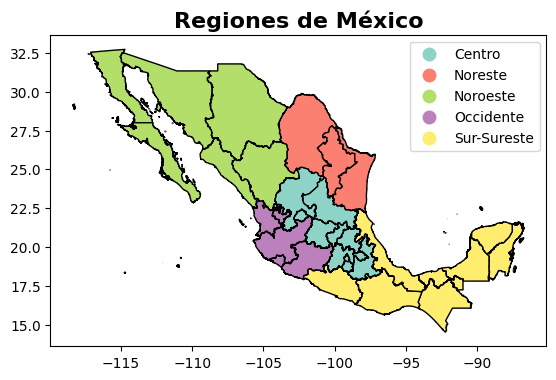

In [19]:
# Verificación
plt.figure(figsize=(5,5))
gdf_estados.plot(column='Region',categorical=True,legend=True,cmap='Set3',edgecolor='black')
plt.title('Regiones de México',fontsize=16,fontweight='bold')
plt.show()

In [20]:
estados_region = gdf_estados[['NOMGEO','geometry','Region']]
estados_region.head(3)

NOMGEO                                           geometry  \
0       Aguascalientes  POLYGON ((-102.29739 22.45527, -102.29554 22.4...   
1      Baja California  MULTIPOLYGON (((-114.11561 28.09639, -114.1152...   
2  Baja California Sur  MULTIPOLYGON (((-109.89451 22.87476, -109.8946...   

     Region  
0    Centro  
1  Noroeste  
2  Noroeste

### 1.6 Incendios a GeoDataFrame

In [21]:
# Dataframe de puntos de incendios e estados
incendios = df_clean[['Estado','latitud','longitud']]
incendios_gdf = gpd.GeoDataFrame(
    incendios,
    geometry=gpd.points_from_xy(incendios.longitud, incendios.latitud),
    crs='EPSG:4326'
)
incendios_gdf.head()

Estado    latitud    longitud                     geometry
0  Aguascalientes  21.995503 -102.750478   POINT (-102.75048 21.9955)
1  Aguascalientes  21.773878 -102.300881  POINT (-102.30088 21.77388)
2  Aguascalientes  21.785075 -102.319444  POINT (-102.31944 21.78508)
3  Aguascalientes  22.224067 -102.336411  POINT (-102.33641 22.22407)
4  Aguascalientes  22.041083 -101.973917  POINT (-101.97392 22.04108)

In [22]:
incendios_gdf['geometry']

0         POINT (-102.75048 21.9955)
1        POINT (-102.30088 21.77388)
2        POINT (-102.31944 21.78508)
3        POINT (-102.33641 22.22407)
4        POINT (-101.97392 22.04108)
                    ...             
71084    POINT (-103.13449 22.09743)
71085    POINT (-104.22502 22.76598)
71086    POINT (-103.54296 21.17366)
71087    POINT (-102.58043 22.78138)
71088    POINT (-102.56816 22.77977)
Name: geometry, Length: 71086, dtype: geometry

##### 1.6.1 Intersección con las Regiones del País

In [23]:
# Asegurar mismas coordenada
gdf_estados = gdf_estados.to_crs(epsg=4326)
incendios_gdf = incendios_gdf.to_crs(epsg=4326)

# Interseccion entre incendios y estados
gdf_incendios = gpd.sjoin(
    incendios_gdf,
    gdf_estados[['NOMGEO','geometry']],
    how='inner',
    predicate='within'
)

In [24]:
gdf_incendios.columns

Index(['Estado', 'latitud', 'longitud', 'geometry', 'index_right', 'NOMGEO'], dtype='object')

In [37]:
# Agregando columna de Region
gdf_incendios_region = gdf_incendios.merge(
    gdf_estados[['NOMGEO','Region']],
    on='NOMGEO',
    how='left'
)
gdf_incendios_region = gdf_incendios_region.drop(columns=['index_right'])
gdf_incendios_region.head()

Estado    latitud    longitud                     geometry  \
0  Aguascalientes  21.995503 -102.750478   POINT (-102.75048 21.9955)   
1  Aguascalientes  21.773878 -102.300881  POINT (-102.30088 21.77388)   
2  Aguascalientes  21.785075 -102.319444  POINT (-102.31944 21.78508)   
3  Aguascalientes  22.224067 -102.336411  POINT (-102.33641 22.22407)   
4  Aguascalientes  22.041083 -101.973917  POINT (-101.97392 22.04108)   

           NOMGEO  Region  
0  Aguascalientes  Centro  
1  Aguascalientes  Centro  
2  Aguascalientes  Centro  
3  Aguascalientes  Centro  
4  Aguascalientes  Centro

## 2. Visualizaciones

### 2.1 Número de incendios por año

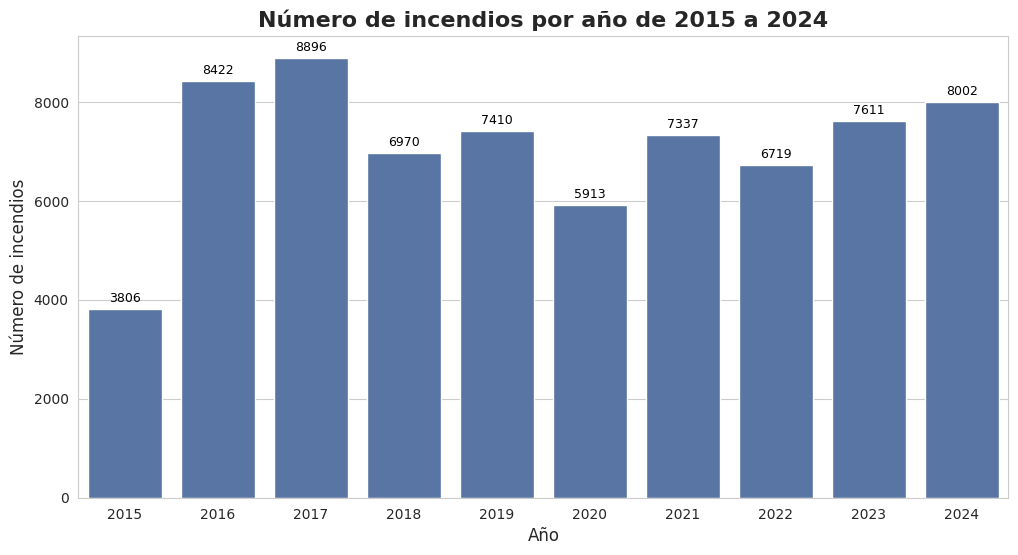

In [26]:
sns.set_style('whitegrid')
sns.set_palette('deep')
plt.figure(figsize=(12,6))
ax = sns.countplot(
    x='anio',
    data=df_clean,
)
for container in ax.containers:
    ax.bar_label(container,padding=3,fontsize=9,color='black')

plt.xlabel('Año',fontsize=12)
plt.ylabel('Número de incendios',fontsize=12)
plt.title('Número de incendios por año de 2015 a 2024',fontsize=16,fontweight='bold')
plt.show()

### 2.2 Treemap de Incendios por Estación

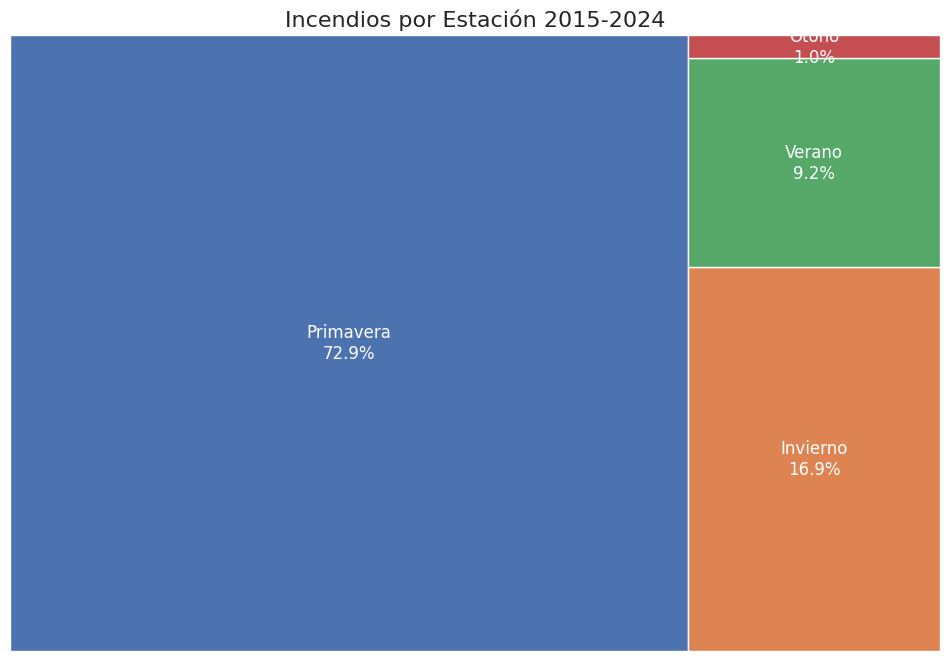

In [27]:
estacion = df_clean['estacion'].value_counts()
labels = [f"{i}\n{v/estacion.sum():.1%}" for i, v in zip(estacion.index, estacion.values)]
# Treemap
plt.figure(figsize=(12,8))
squarify.plot(
    sizes = estacion.values,
    label = labels,
    color=sns.color_palette('deep',n_colors=len(estacion)),
    text_kwargs={'fontsize':12,'color':'white'}
)
plt.title('Incendios por Estación 2015-2024',fontsize=16)
plt.axis('off')
plt.show()

### 2.3 Incendios por Mes (2015-2024)

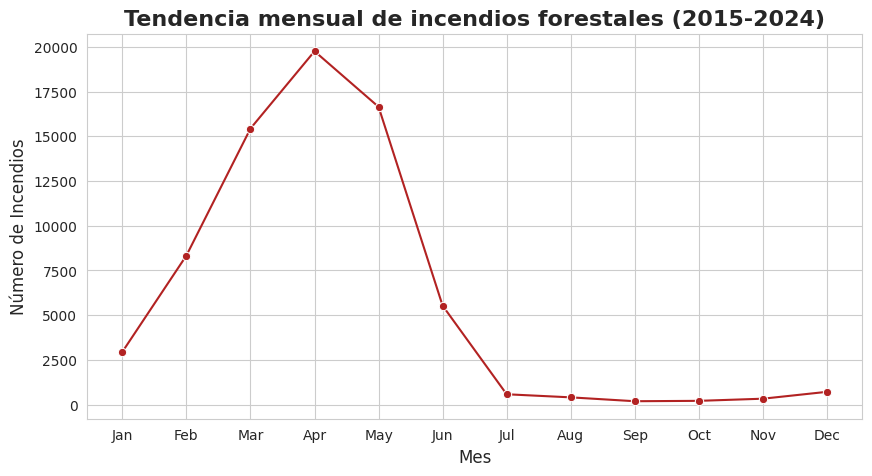

In [28]:
# Promedio mensual
promedio_mensual = (
    df_clean
    .groupby('mes_inicio')
    .size()
    .reindex(range(1,13),fill_value=0)
)

# Graficar
plt.figure(figsize=(10,5))
sns.lineplot(x=promedio_mensual.index,y=promedio_mensual.values,marker='o',color='firebrick')
plt.xticks(ticks=range(1,13),labels=[calendar.month_abbr[m] for m in range(1,13)])
plt.xlabel('Mes',fontsize=12)
plt.ylabel('Número de Incendios',fontsize=12)
plt.title('Tendencia mensual de incendios forestales (2015-2024)',fontsize=16,fontweight='bold')
plt.grid(True)
plt.show()

### 2.3 Incedios Mensuales por Año (2015-2024)

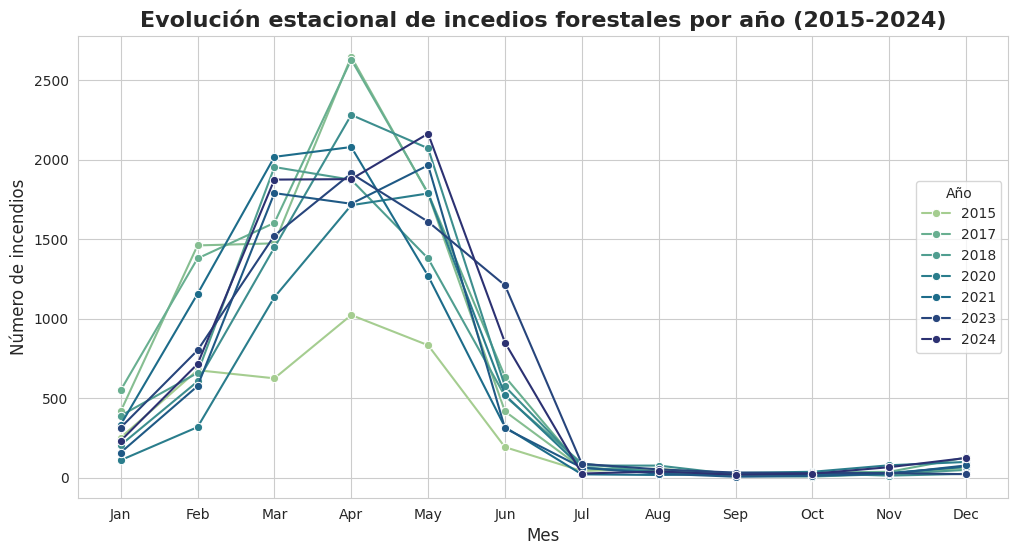

In [29]:
conteo_anual = (
    df_clean
    .groupby(['anio_inicio','mes_inicio'])
    .size()
    .reset_index(name='conteo')
)
plt.figure(figsize=(12,6))
sns.lineplot(
    data=conteo_anual,
    x='mes_inicio',
    y='conteo',
    hue='anio_inicio',
    palette='crest',
    marker='o'
)
plt.xticks(ticks=range(1,13),labels=[calendar.month_abbr[m] for m in range(1,13)])
plt.xlabel('Mes',fontsize=12)
plt.ylabel('Número de incendios',fontsize=12)
plt.title('Evolución estacional de incedios forestales por año (2015-2024)',fontsize=16
          ,fontweight='bold')
plt.legend(title='Año',loc='center right')
plt.show()

### 2.4 Incedios por Causa

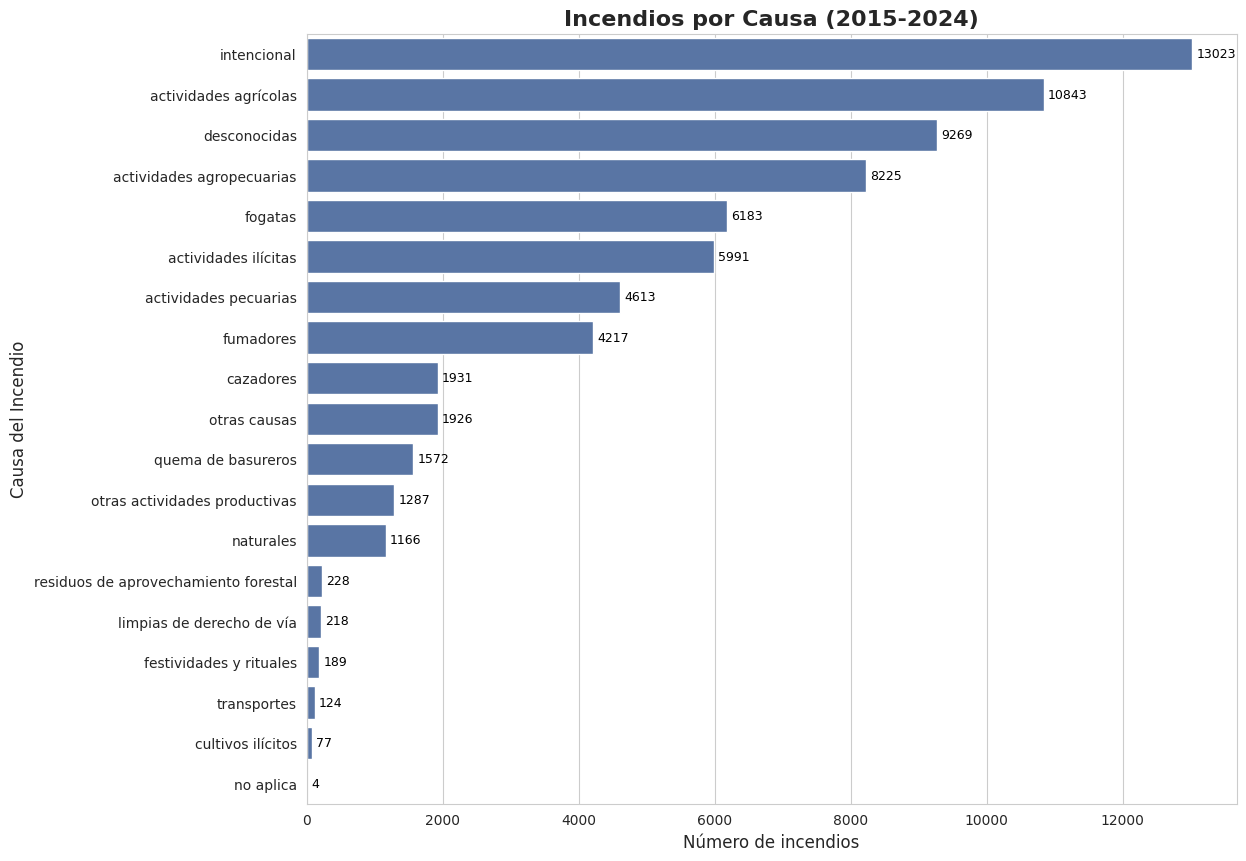

In [30]:
plt.figure(figsize=(12,10))
ax = sns.countplot(
    y='Causa',
    data=df_clean,order=df_clean['Causa'].value_counts().index,
)
for container in ax.containers:
    ax.bar_label(container,padding=3,fontsize=9,color='black')

plt.xlabel('Número de incendios',fontsize=12)
plt.ylabel('Causa del Incendio',fontsize=12)
plt.title('Incendios por Causa (2015-2024)',fontsize=16,fontweight='bold')
plt.show()

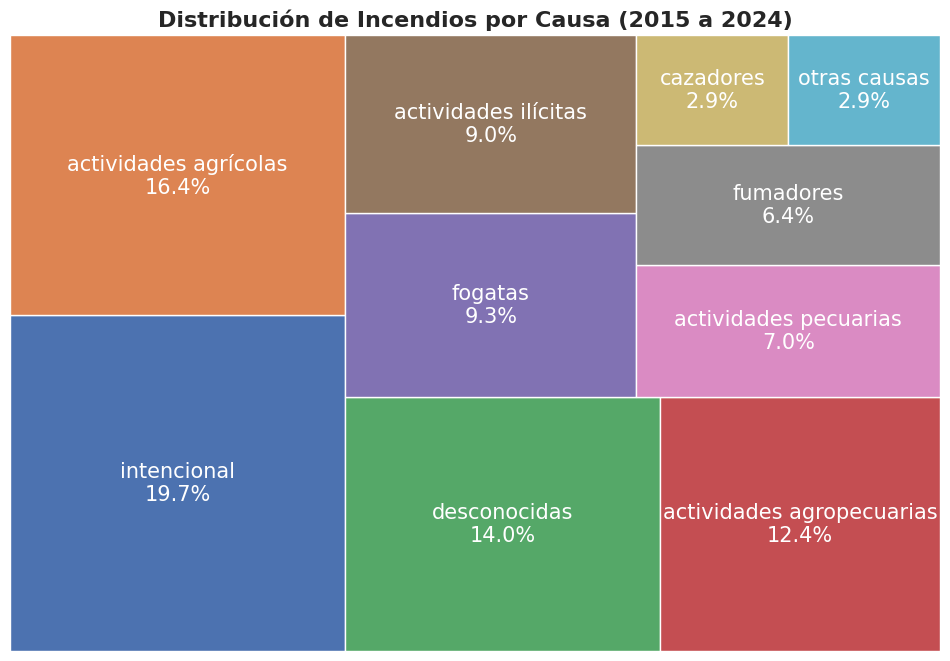

In [31]:
causas = df_clean['Causa'].value_counts().head(10)
labels = [f"{i}\n{v/causas.sum():.1%}" for i, v in zip(causas.index, causas.values)]
# Treemap
plt.figure(figsize=(12,8))
squarify.plot(
    sizes = causas.values,
    label = labels,
    color=sns.color_palette('deep',n_colors=len(causas)),
    text_kwargs={'fontsize':15,'color':'white'}
)
plt.title('Distribución de Incendios por Causa (2015 a 2024)',fontsize=16,fontweight='bold')
plt.axis('off')
plt.show()

### 2.5 Concentración de incendios por mes y año

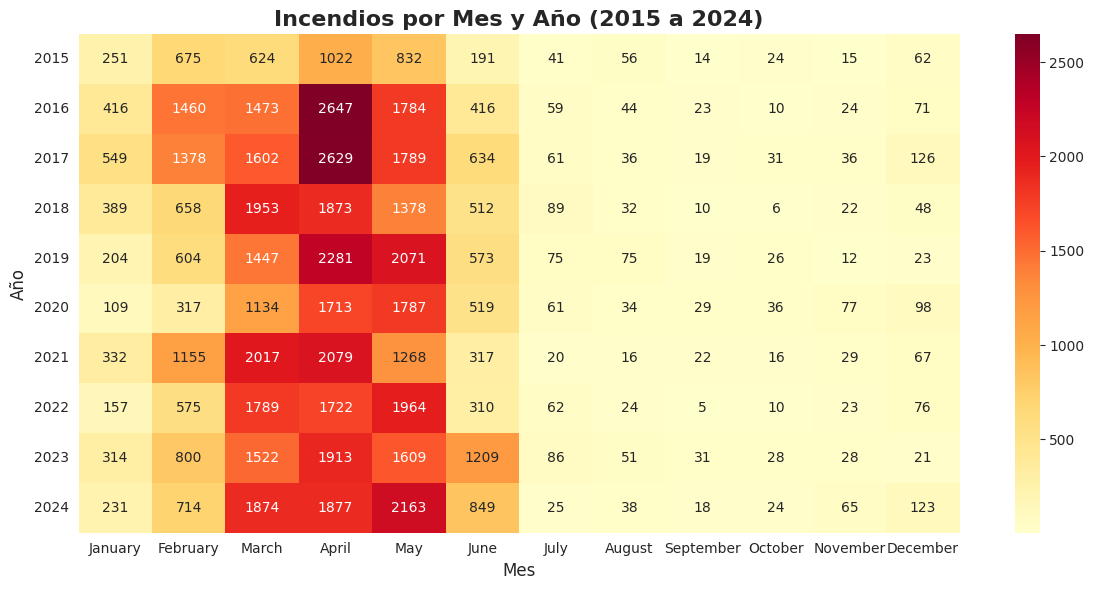

In [32]:
import calendar
tabla = df_clean.pivot_table(
    index='anio_inicio',
    columns='mes_inicio',
    values = 'Causa',
    aggfunc='count',
    fill_value=0
)
tabla.columns = [calendar.month_name[i] for i in tabla.columns]
plt.figure(figsize=(12,6))
sns.heatmap(
    tabla,
    cmap='YlOrRd',
    annot=True,
    fmt='g'
)
plt.title('Incendios por Mes y Año (2015 a 2024)',fontsize=16,fontweight='bold')
plt.xlabel('Mes',fontsize=12)
plt.ylabel('Año',fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 2.5 Distribución espacial de los incendios

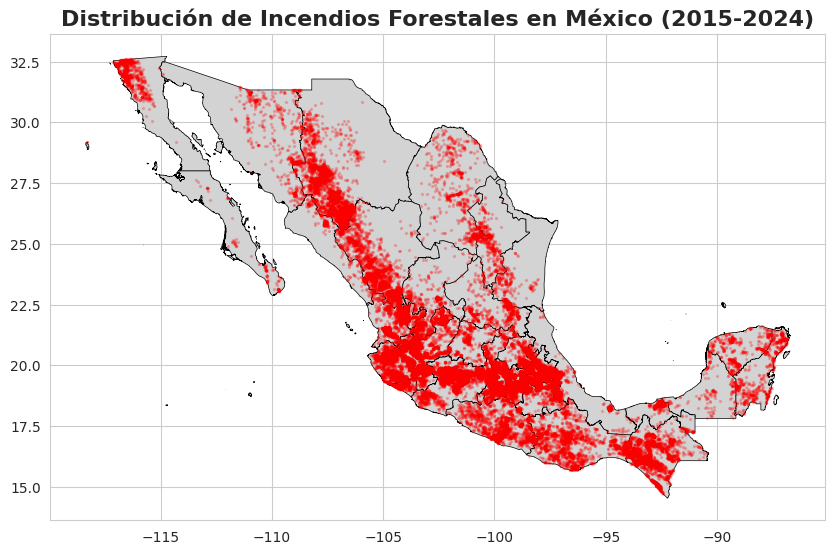

In [33]:
# Incendios por estado
fig,ax = plt.subplots(figsize=(10,10))

# Poligonos estados
gdf_estados.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.5)

# Incendios
gdf_incendios.plot(ax=ax,markersize=2,color='red',alpha=0.2)

ax.set_title('Distribución de Incendios Forestales en México (2015-2024)',fontsize=16,
              fontweight='bold')
plt.show()

### 2.6 Incendios por estado

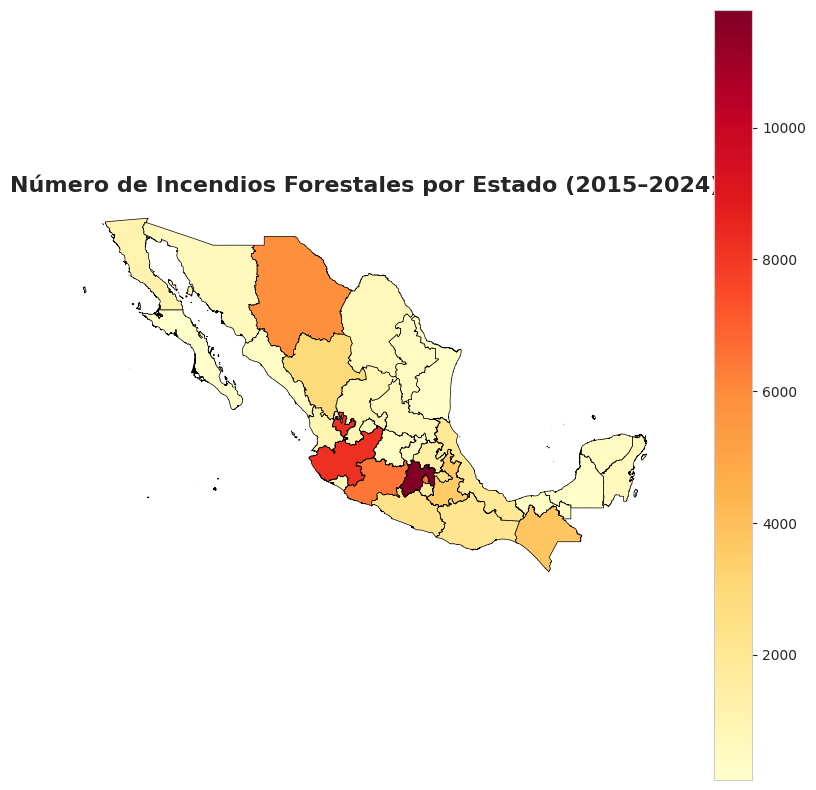

In [34]:
# Incendios por estado
conteo_estados = (
    gdf_incendios
    .groupby('NOMGEO')
    .size()
    .reset_index(name='Incendios')
)
# Unir con geodataframe de estados
gdf_mapa = gdf_estados.merge(
    conteo_estados,
    on='NOMGEO',
    how='left'
)

# Graficar
fig,ax = plt.subplots(figsize=(10,10))
gdf_mapa.plot(
    column='Incendios',
    cmap='YlOrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title('Número de Incendios Forestales por Estado (2015–2024)', fontsize=16,
             fontweight='bold')
ax.axis('off')
plt.show()

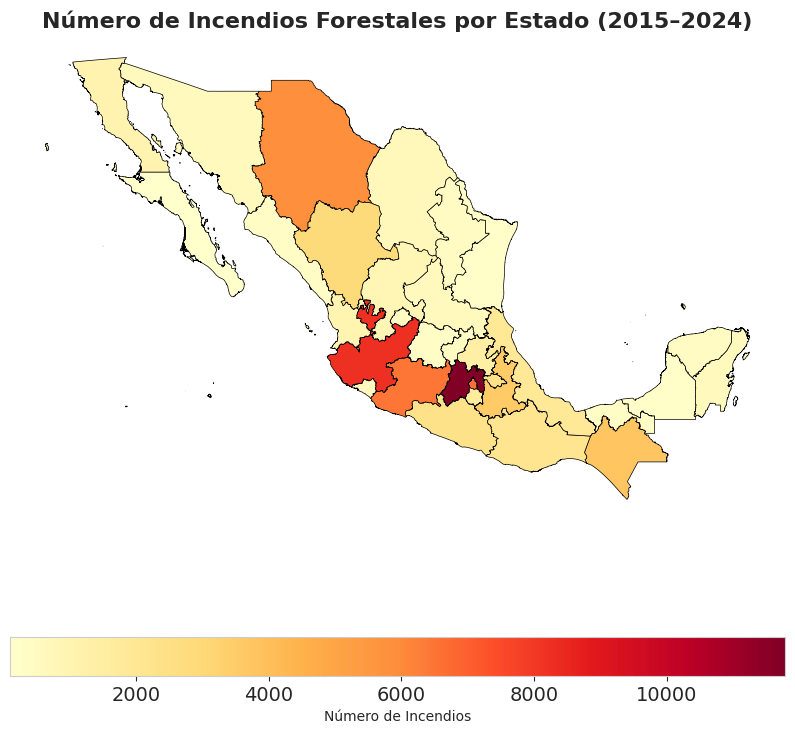

In [62]:
# Incendios por estado
conteo_estados = (
    gdf_incendios
    .groupby('NOMGEO')
    .size()
    .reset_index(name='Incendios')
)
# Unir con geodataframe de estados
gdf_mapa = gdf_estados.merge(
    conteo_estados,
    on='NOMGEO',
    how='left'
)

# Graficar
fig,ax = plt.subplots(figsize=(10,10))
gdf_mapa.plot(
    column='Incendios',
    cmap='YlOrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds = {'label':'Número de Incendios','orientation':'horizontal'},
    ax=ax
)
ax.set_title('Número de Incendios Forestales por Estado (2015–2024)', fontsize=16,
             fontweight='bold')
ax.axis('off')
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=14)
plt.show()

### 2.7 Incendios por Región

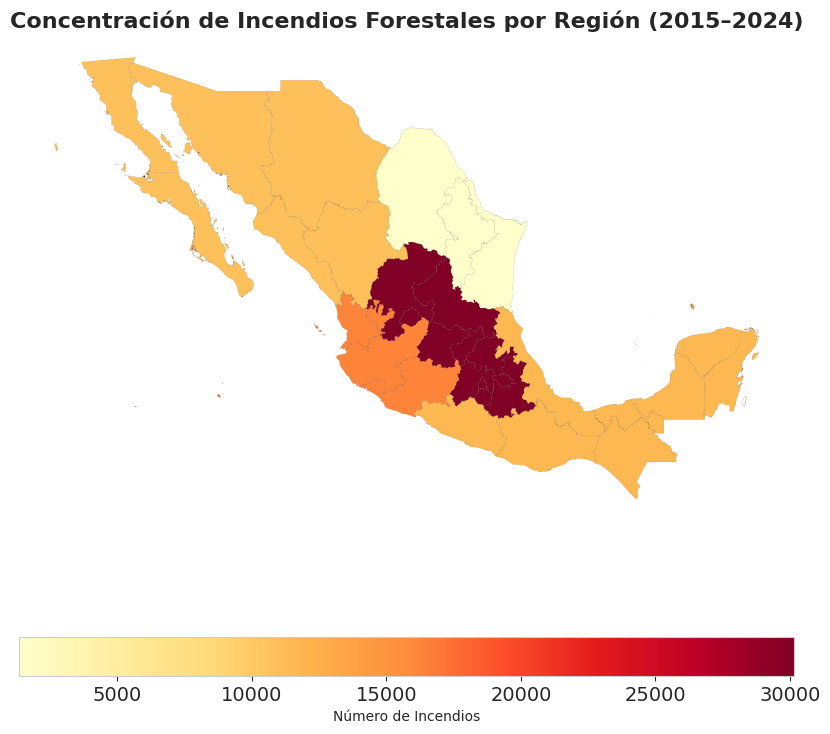

In [67]:
conteo_estados_region = (
    gdf_incendios_region
    .groupby('Region')
    .size()
    .reset_index(name='Incendios')
)
# Unir con geodataframe de estados
gdf_mapa_region = gdf_estados.merge(
    conteo_estados_region,
    on='Region',
    how='left'
)

# Graficar
fig,ax = plt.subplots(figsize=(10,10))
gdf_mapa_region.plot(
    column='Incendios',
    cmap='YlOrRd',
    linewidth=0.05,
    edgecolor='black',
    legend=True,
    legend_kwds = {'label':'Número de Incendios','orientation':'horizontal'},
    ax=ax
)
ax.set_title('Concentración de Incendios Forestales por Región (2015–2024)', fontsize=16,
             fontweight='bold')
ax.axis('off')
# Colorbar
cb_ax = fig.axes[1]
# Tamaño de los número del colorbar
cb_ax.tick_params(labelsize=14)
plt.show()